# Neural Network Classifier 

We are going to build a PyTorch neural network classifier using scRNAseq data. 

Helpful link:
Interfacing pytorch models with anndata: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html

Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- pull in scRNAseq data from cell_census
- wrangle the data for modelling
- appply the NN



## To Do:

- train, test, holdout and cross validation
- feature engineering to remove useless features
- ensure that leaf order matches in all the things
- when splitting the data for training/validation,  ensure that the number of genes is the same in both

## Done:
- use softmax for final layer
- use Cross entropy loss
- try ADAM optimizer, adjust learning rate
- plot loss curve
- use RELU for each layer
- plot accuracy curve
- add model.trend() and model.eval()
- add batch summarization 



In [1]:
import cell_census
import anndata as ad

from pronto import Ontology

import pandas as pd
import numpy as np
import math as math
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Read in the data

For now, we're going to select all 10X 3' V3 leukocyte and lymphocyte human data 

- CL:0000738 = leukocyte
- CL:0000542 = lymphocyte


Using ```development-stage``` for the target value because there are 6 unique values, so we have a multi-class classification problem, which will match our eventual goal. This is a place holder until we get a little further in the development of everything.

In [3]:
census = cell_census.open_soma(census_version="latest")


In [4]:
cl = Ontology.from_obo_library('cl.owl')

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}description' at 0x7feaf804f450> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}title' at 0x7feaf804f540> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://www.w3.org/2002/07/owl#}versionInfo' at 0x7feaf804fc70> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:113: SyntaxWarning: unknown elem

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}RO_0004050
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.org/dc/terms/}contributor
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://xmlns.com/foaf/0.1/}depicted_by
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://www.geneontology.org/formats/oboInOwl#}note
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/pyt

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000001'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000003'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000012'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000008'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/li

In [5]:
def select_ontology_target_leafs(target_branch):
    '''
    This function identifies are leafs under the target_branch for an open ontology.
    
    Assumes there is an active ontology already open as cl.
    
    Parameters
    ----------
    target_branch : string
        string with ontological ID for branch you want to identify leafs for
        
    Returns
    -------
    leaf_lest : list
        list of ontology IDs for all leafs of target_branch
    
    '''
    root_node = cl[target_branch] 

    leaf_list = []

    for term in root_node.subclasses(distance=None,with_self=False).to_set():
        if term.is_leaf():
            leaf_list.append(term.id)
            
    return leaf_list

In [6]:
def get_data(organism, obs_val_filter, col_names):
    '''
    This function queries data from an active cell census object.
    
    Assumes there is an active census object already open. Assumes you only want to query on cell metadata. 
    Gene metadata querying not currently supported.
    
    Parameters
    ----------
    organism : string
        string containing type of organism you want to query for, i.e. 'Homo sapiens'
        
    obs_val_filter : string
        string containing obs parameters values to filter on
        
    col_names : dictionary
        dictionary of obs or val values to return
        
    Returns
    -------
        AnnData object
    
    '''
    adata = cell_census.get_anndata(
        census=census,
        organism = organism,
        obs_value_filter = obs_val_filter,
        column_names= col_names,
        )
    return adata
    

In [7]:
target_branch = 'CL:0000542' # lymphocyte

leaf_list = select_ontology_target_leafs(target_branch)



In [8]:
leaf_list

['CL:0000918',
 'CL:0009037',
 'CL:0000973',
 'CL:0000935',
 'CL:0000907',
 'CL:0000917',
 'CL:0000948',
 'CL:2000006',
 'CL:0011018',
 'CL:0009081',
 'CL:0000919',
 'CL:0002039',
 'CL:0000903',
 'CL:0001044',
 'CL:0002120',
 'CL:0000895',
 'CL:0002435',
 'CL:0002442',
 'CL:0009050',
 'CL:0000982',
 'CL:0000949',
 'CL:2000054',
 'CL:0009044',
 'CL:0002345',
 'CL:0000934',
 'CL:0009112',
 'CL:0002128',
 'CL:0000910',
 'CL:0002407',
 'CL:0000950',
 'CL:0000925',
 'CL:0000929',
 'CL:0002103',
 'CL:0002123',
 'CL:0001087',
 'CL:0000976',
 'CL:0002338',
 'CL:0000944',
 'CL:0002107',
 'CL:0002106',
 'CL:0000961',
 'CL:4030030',
 'CL:0009033',
 'CL:0002110',
 'CL:0002124',
 'CL:0000977',
 'CL:0001049',
 'CL:0001079',
 'CL:0009059',
 'CL:0000820',
 'CL:0000971',
 'CL:0002446',
 'CL:0009082',
 'CL:0002406',
 'CL:0001075',
 'CL:0009023',
 'CL:0000963',
 'CL:0002415',
 'CL:0001080',
 'CL:0000987',
 'CL:0009068',
 'CL:0002444',
 'CL:0001046',
 'CL:0001073',
 'CL:0000805',
 'CL:0002102',
 'CL:00021

In [37]:
print('''assay == "10x 3\' v3" and cell_type_ontology_term_id in {}'''.format(leaf_list))

assay == "10x 3' v3" and cell_type_ontology_term_id in ['CL:0002413', 'CL:0000956', 'CL:0000951', 'CL:0002106', 'CL:0002434', 'CL:0000966', 'CL:0002430', 'CL:0001042', 'CL:0002416', 'CL:0000958', 'CL:0002061', 'CL:0000937', 'CL:0002445', 'CL:0001046', 'CL:0000982', 'CL:0002345', 'CL:0002679', 'CL:0002089', 'CL:0009114', 'CL:0002103', 'CL:0000932', 'CL:0001077', 'CL:0000960', 'CL:0002429', 'CL:0000978', 'CL:0009064', 'CL:0000977', 'CL:0000903', 'CL:0011024', 'CL:0000935', 'CL:0002442', 'CL:0009044', 'CL:0000545', 'CL:0002052', 'CL:0009032', 'CL:0000933', 'CL:0001044', 'CL:0002439', 'CL:0000900', 'CL:0002050', 'CL:0000984', 'CL:0000934', 'CL:0002444', 'CL:0001050', 'CL:0000963', 'CL:0002406', 'CL:0002427', 'CL:0009046', 'CL:0002127', 'CL:0002446', 'CL:2000006', 'CL:0009062', 'CL:0001081', 'CL:0000927', 'CL:0001048', 'CL:0001202', 'CL:0002120', 'CL:0000926', 'CL:0001049', 'CL:0002423', 'CL:0002042', 'CL:0009112', 'CL:0002218', 'CL:0000920', 'CL:0009051', 'CL:0000805', 'CL:0000965', 'CL:00

In [7]:
obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in ['CL:0001044', 'CL:0000900', 'CL:0000934','CL:0001050','CL:0001049']'''
#obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in ['CL:0001044', 'CL:0000900']'''

#obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in {}'''.format(leaf_list)


organism = "Homo sapiens"
col_names = {"obs": ["cell_type_ontology_term_id"]}
#col_names = {} # select all

adata = get_data(organism, obs_val_filter, col_names)

In [8]:
display(adata)

AnnData object with n_obs × n_vars = 63363 × 60664
    obs: 'cell_type_ontology_term_id', 'assay'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [10]:
# the data is stored in adata.X
adata.X

# find the number of features (genes)

adata.X.shape[1]

60664

## Encode and Split the Data into Train/Validate to prepare for modeling

Encode the label values, then split the data into testing and training sets, then put into PyTorch Tensors.

Using self_reported_ethnicity for the labels

In [11]:
def preprocess_data(adata, target_column):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    lb = LabelEncoder()
    labels['encoded_labels'] = lb.fit_transform(labels[target_column])

    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    return(x_data,y_data, labels)

In [36]:
def split_format_data(x_data, y_data, train_size):
    '''
    This function splits x_data and y_data into training and validation sets, then formats the data into
    tensors for modeling with PyTorch
    
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    y_data : Series
        Pandas series of encoded target values
        
    train_size: float
        float between 0.0 and 1.0 to select the training fraction of the data set
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    '''
    
    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                   train_size = train_size)
    
    
    # check if number of genes in X_train = X_val
    # rarely, splitting the dataset can cause a difference
    # if it does, resplit the data by looping back into this function
    
    while X_train.shape[1] != X_val.shape[1]:
        print('Warning! Number of genes in X_train does not equal number of shapes in X_val. Resplitting')
        X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                   train_size = train_size)
    if X_train.shape[1] != X_val.shape[1]:
        print('Warning! you messed it up')

    
    # convert the data to tensors
    # we'll change the data from CSR (compressed sparse row) format
    # to COO (coordinate) format for better use with pytorch
    # see https://pytorch.org/docs/stable/sparse.html for additional details

    X_train_coo = X_train.tocoo()

    X_train = torch.sparse.LongTensor(torch.LongTensor([X_train_coo.row.tolist(),X_train_coo.col.tolist()]),
                                     torch.LongTensor(X_train_coo.data.astype(np.float32)))

    # y_train is a Series, so it is easier to convert to a tensor
    y_train = torch.tensor(y_train, dtype=torch.long)


    # and the same for the validation set
    X_val_coo = X_val.tocoo()

    X_val = torch.sparse.LongTensor(torch.LongTensor([X_val_coo.row.tolist(),X_val_coo.col.tolist()]),
                                     torch.LongTensor(X_val_coo.data.astype(np.float32)))

    # y_val is a Series, so it is easier to convert to a tensor
    y_val = torch.tensor(y_val, dtype=torch.long)
            
    return(X_train, X_val, y_train, y_val)

In [13]:
def preprocess_ontology(adata,target_column,upper_limit = None, include_leafs = False, cl_only = False):
    '''
    This function processes the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Does not have a forced upper limit in the ontology.
    
    Assumes there is an active census object already open as cl. 
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    Returns
    -------
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # select the unique target values
    target_values = labels[target_column].unique()
    
    # check that these are leaf nodes
    # if not, find the leaf under that value
    leaf_nodes = []
    for target in target_values:
        if cl[target].is_leaf():
            leaf_nodes.append(target)
        else:
            for term in cl[target].subclasses(distance=None,with_self=False).to_set():
                if term.is_leaf():
                    leaf_nodes.append(term.id)
    
    # ensure that we do not have duplicate values
    leaf_nodes = list(set(leaf_nodes))
    
    
    # now get all parent nodes
    # if we want to include leafs, set with_self = True
    # else, set with_self = False
    parent_nodes = []
    for target in target_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            parent_nodes.append(term.id)
            
    # ensure that we do not have duplicate values
    parent_nodes = list(set(parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        parent_nodes = [x for x in parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)
            
        # remove these nodes from the parent_nodes list
        parent_nodes = [x for x in parent_nodes if x not in upper_limit_nodes]
        
    
    # create the dataframe
    ontology_df = pd.DataFrame(data=0, index = parent_nodes,
                                              columns = leaf_nodes)


    # populate the dataframe with 1 if column leaf is a leaf 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]
                    
    
    return(ontology_df)

In [44]:
target_column = 'cell_type_ontology_term_id'

upper_limit = 'CL:0000738' # leukocyte = 738

ontology_df = preprocess_ontology(adata,target_column,upper_limit = upper_limit, include_leafs = False, cl_only=True)

x_data, y_data, labels = preprocess_data(adata,target_column)

train_size = 0.70

X_train, X_val, y_train, y_val = split_format_data(x_data, y_data, train_size)


In [54]:
ontology_df

,CL:0001044,CL:0000934,CL:0000900
CL:0000898,0,0,1
CL:0000791,1,1,1
CL:0000624,1,1,0
CL:0000625,0,0,1
CL:0000789,1,1,1
CL:0002419,1,1,1
CL:0000911,1,0,0
CL:0000738,1,1,1
CL:0000084,1,1,1
CL:0000842,1,1,1


In [9]:
# select the labels. 
# labels = adata.obs

# labels['development_stage'].value_counts()

# lb = LabelEncoder()
# labels['encoded_labels'] = lb.fit_transform(labels['development_stage'])
# labels.head(10)

seventh decade human stage                  23747
sixth decade human stage                    17581
eighth decade human stage                   12497
fifth decade human stage                    10029
fourth decade human stage                    9232
                                            ...  
39-year-old human stage                        34
10th week post-fertilization human stage       27
72-year-old human stage                        18
20th week post-fertilization human stage       13
74-year-old human stage                         7
Name: development_stage, Length: 77, dtype: int64

In [11]:
# find the number of unique labels
labels['encoded_labels'].nunique()

77

## Build Neural Network Classifier

based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

another helpful resource: https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model

In [16]:
test_size = torch.unique(y_train).size(dim=0)

test_size

5

In [17]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of hidden layers
hidden_layers = 10

# number of classes (unique of y)
output_dim = torch.unique(y_train).size(dim=0) #labels['encoded_labels'].nunique()

In [18]:
print(input_dim,hidden_layers,output_dim)

60614 10 5


In [19]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layers)
        self.linear2 = nn.Linear(hidden_layers,output_dim)
        self.bn = nn.BatchNorm1d(10)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x,dim=1)
        return x

## Train the Model

In [27]:
# initialize network

clf = Network()

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

epochs = 100
accuracy_vals = []
loss_vals = []

# set the model to training
clf.train()

for epoch in range(epochs):
    running_loss = 0.0

    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
  
    # forward propagation
    outputs = clf(X_train.float())
    loss = criterion(outputs, y_train)
    
    # backward propagation
    loss.backward()
    
    # optimize
    optimizer.step()
    running_loss += loss.item()
    
    # save accuracy
    _, epoch_pred = outputs.max(dim=1)
    correct = (epoch_pred == y_train).sum().item()
    accuracy_vals.append(correct / len(y_train) * 100.)

    # save loss
    loss_vals.append(loss.item())
    
    # display statistics
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.8f} accuracy: {accuracy_vals[-1]:.4f}')


[1] loss: 1.61728120 accuracy: 13.2490
[10] loss: 1.52344155 accuracy: 55.4209
[20] loss: 1.46894157 accuracy: 70.0381
[30] loss: 1.43148994 accuracy: 73.6231
[40] loss: 1.39798081 accuracy: 78.6283
[50] loss: 1.36467600 accuracy: 82.3000
[60] loss: 1.33435214 accuracy: 86.1967
[70] loss: 1.30199873 accuracy: 90.2148
[80] loss: 1.27349961 accuracy: 94.0423
[90] loss: 1.24101067 accuracy: 95.8261
[100] loss: 1.21379137 accuracy: 96.7960


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_46767/353249328.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


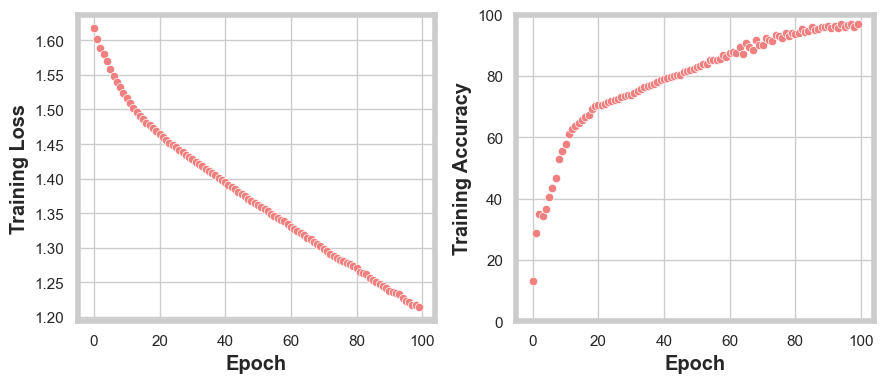

In [28]:
# plot the loss and accuracy curves

fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(epochs),y=loss_vals, ax = ax[0],color='lightcoral')
sns.scatterplot(x=range(epochs),y=accuracy_vals, ax = ax[1],color='lightcoral')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')
ax[1].set_ylim((0,100))
fig.show()

## Validate the model

Most of this work is based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2



In [29]:
clf.eval()

outputs_val = clf(X_val.float())
__, predicted = torch.max(outputs_val,1)
print(predicted)

tensor([4, 2, 4,  ..., 0, 0, 3])


In [30]:
torch.unique(predicted, return_counts=True)

(tensor([0, 1, 2, 3, 4]), tensor([ 7259,  6160, 13600, 12697, 12257]))

In [31]:
clf.eval()

correct, total = 0, 0

with torch.no_grad():
    # calculate output by running through the network
    outputs = clf(X_val.float())
    
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    
    # update results
    total += y_val.size(0)
    correct += (predicted == y_val).sum().item()
    
print(f'Accuracy of the network on the test data: {100 * correct // total:.2f} %')

Accuracy of the network on the test data: 88.00 %


## Train and Validate Together

Let's write a function to to the training and validation all at once, so we can compare loss/accuracy curves.

helpful for hyperparameter tuning: https://machinelearningmastery.com/training-and-validation-data-in-pytorch/

In [48]:
def train_and_validate(num_epochs):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. 
    
    Parameters
    ----------
    num_epochs : int
        integer specify the number of epochs
        
    Returns
    -------
    accuracy_train_hist : list
        list containing accuracy for the training set per epoch
        
    loss_train_hist: list
        list containing loss values for the training set per epoch
        
    accuracy_val_hist : list 
        list containing accuracy for the validation set per epoch
        
    loss_val_hist : list
        list containing loss values for the validation set per epoch
    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    # define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0

        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # forward propagation
        outputs_train = clf(X_train.float())
        loss_train = criterion(outputs_train, y_train)

        # backward propagation
        loss_train.backward()

        # optimize
        optimizer.step()
        running_train_loss += loss_train.item()

        # save accuracy
        _, train_pred = outputs_train.max(dim=1)
        correct_train = (train_pred == y_train).sum().item()
        accuracy_train_hist.append(correct_train / len(y_train) * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)

            # calculate loss
            loss_val = criterion(outputs_val, y_val)

            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.3f} Validation Accuracy: {accuracy_val_hist[-1]:.3f}')

    print(f'Best Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    return(accuracy_train_hist, loss_train_hist, accuracy_val_hist, loss_val_hist, best_output)

        

In [49]:
# set the number of epochs and run the model

num_epochs = 11

accuracy_train_hist, loss_train_hist, accuracy_val_hist, loss_val_hist, best_output = train_and_validate(num_epochs)

[1] Training Accuracy: 28.860 Validation Accuracy: 46.450
[10] Training Accuracy: 81.587 Validation Accuracy: 85.998
Best Accuracy: 86.137


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_75693/488324102.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


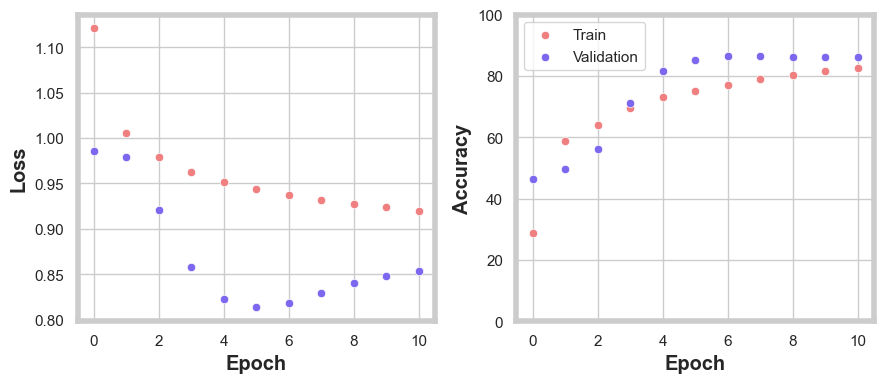

In [50]:


fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(num_epochs),y=loss_train_hist, ax = ax[0],color='lightcoral')
sns.scatterplot(x=range(num_epochs),y=accuracy_train_hist, ax = ax[1],color='lightcoral',label='Train')

sns.scatterplot(x=range(num_epochs),y=loss_val_hist, ax = ax[0],color='mediumslateblue')
sns.scatterplot(x=range(num_epochs),y=accuracy_val_hist, ax = ax[1],color='mediumslateblue',label='Validation')


ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim((0,100))
fig.show()

## Functions for dealing with tree ontology and loss

1) Inverse transform classifications into ontology IDs
2) Match IDs with probabilities
3) Identify parents
4) Sum probablities

best_output is a tensor of probabilities by class

In [34]:
def find_parent(subclass, distance=1):
    '''
    Finds parent(s) of input subclass for current ontology, which must be loaded as cl. Parents will be 
    found within input distance of subclass. Immediate parents correspond with distance = 1. 
    
    Parameters
    ----------
    subclass : str
        string with full name of subclass you want to identify the parents of
        
    distance (optional): int
        distance from subclass you want to find parents of
        default = 1
        
    Returns
    -------
    parents : list
        list of parents for input subclass
    '''
    root_node = cl[subclass]
    parents = []
    for term in root_node.superclasses(distance=distance,with_self=False).to_set():
        parents.append(term.id)
    return parents

In [30]:
def add_probability_to_parent_nodes(ids,prob,probability_dict,count_twice=True,new_parent_records=None,top_parent = 'CL:0000000'):
    '''
    Add probability of ids node to each parent node in the ontology.
    
    A current ontology must be loaded as CL.
    
    If multiple parents loop back to the same super-parent, probability will be summed twice. 

    Parameters
    ----------
    ids : str
        string with full name of subclass you want to sum the probabilities for
        
    prob : float
        distance from subclass you want to find parents of

    probability_dict : dict
        dictionary to add probabilities to, with keys being the relevant ontology IDs
        can either be an empty dictionary or an existing dictionary
        
    count_twice : Boolean
        whether or not to count redundant parents twice 
        default = True
        
    new_parent_records : list
        list of parents added to probability dict. used in conjuction with count_twice
        default = None
        
    top_parent : string
        top level of ontology you wish you classify to. Used only if you want to classify to a subset
        of the ontology
        default = 'CL:0000000' (Cell in the Cell Ontology)
        
    Returns
    -------
    parents : list
        list of parents for input subclass
    '''

    # get parent ids
    parents_of_id = find_parent(ids)

    # keep record of parent IDs that have been added
    if new_parent_records is None:
        new_parent_records = []
    
    # if top parent ID in the list of new parent records, then done
    # if not, then add probability to each parent
    # for each parent, check if ID has a parent
    if top_parent in parents_of_id:
        # we're at the final node. Add probability to this node, then exit
        if top_parent in probability_dict:
            probability_dict[top_parent] += prob
        else:
            probability_dict[top_parent] = prob
        pass
    else:
        for parent in parents_of_id:
            if count_twice == True:
                if parent in probability_dict:
                    probability_dict[parent] += prob
                else:
                    probability_dict[parent] = prob
                probability_dict = add_probability_to_parent_nodes(parent,prob,probability_dict,new_parent_records=new_parent_records,count_twice=True,top_parent=top_parent)
            elif count_twice == False:
                # check if parent in new_parent_records
                # if so, pass
                # if not, add to dict
                if parent in new_parent_records:
                    pass
                else:
                    if parent in probability_dict:
                        probability_dict[parent] += prob
                    else:
                        probability_dict[parent] = prob
                    new_parent_records.append(parent)
                    probability_dict = add_probability_to_parent_nodes(parent,prob,probability_dict,new_parent_records=new_parent_records,count_twice=False,top_parent=top_parent)
    return(probability_dict)



In [41]:
def get_tree(root,tree_dict,level=0,top_parent = 'CL:0000000'):
    '''
    Determines tree structure starting with a leaf and identifying all superclasses/parents
    
    Parameters
    ----------
    root : str
        string with full name of ID you want to identify the parents of
        
    tree_dict : dictionary
        dictionary with tree. keys are levels, where level=0 is the initial leaf.
        values are ontology IDs
        
    level (optional): int
        level of root to build tree dictionary
        default = 0
        
    top_parent : string
        top level of ontology you wish you classify to. Used only if you want to return a subset
        of the ontology
        default = 'CL:0000000' (Cell in the Cell Ontology)
        
    Returns
    -------
    tree_dict : dictionary
        dictionary of tree given inital root. 
        keys are levels, where level=0 is the initial leaf.
        values are ontology IDs
        There will be duplicates in the keys because of multiple inheritance
        Can run list(set(key)) to remove duplicates
    '''


    # add root to dictionary if level = 0
    # need to check if level in tree_dict in case
    # we are iterating over multiple leafs
    if level == 0:
        if level in tree_dict:
            tree_dict[level].append(root)
        else:
            tree_dict[level] = [root]
    
    # get parent ids
    parents_of_id = find_parent(root)
    level += 1
    
    # add parents to dictionary
    if level in tree_dict:
        tree_dict[level] += parents_of_id
    else:
        tree_dict[level] = parents_of_id

    if top_parent in parents_of_id: #parents_of_id is None:
        pass
    else:
        for parent in parents_of_id:
            tree_dict = get_tree(parent,tree_dict,level=level,top_parent = top_parent)
    
    return tree_dict


In [42]:

root_ids = 'CL:0000934'
tree_test_dict = {}
tree_test_dict = get_tree(root_ids,tree_test_dict,level=0,top_parent = 'CL:0000738')

tree_test_dict


{0: ['CL:0000934'],
 1: ['CL:0000624'],
 2: ['CL:0000791'],
 3: ['CL:0002419', 'CL:0000789'],
 4: ['CARO:0000006', 'CL:0000084', 'CARO:0000006', 'CL:0000084'],
 5: ['CARO:0000000', 'CL:0000542', 'CARO:0000000', 'CL:0000542'],
 6: ['CARO:0030000',
  'CL:0000842',
  'PR:000050567',
  'CARO:0030000',
  'CL:0000842',
  'PR:000050567'],
 7: ['BFO:0000004',
  'CL:0000738',
  'CL:0000226',
  'BFO:0000040',
  'BFO:0000004',
  'CL:0000738',
  'CL:0000226',
  'BFO:0000040'],
 8: ['BFO:0000002', 'BFO:0000004', 'BFO:0000002', 'BFO:0000004'],
 9: ['BFO:0000002', 'BFO:0000002'],
 10: []}

In [31]:
# get one ID from best_output tensor

ids = 'CL:0000934'
prob = 0.3

# set up final probability dictionary
probability_dict = {}
top_parent = 'CL:0000738'

new_dict = add_probability_to_parent_nodes(ids,prob,probability_dict,count_twice=False,top_parent=top_parent)


new_dict

{'CL:0000624': 0.3,
 'CL:0000791': 0.3,
 'CL:0002419': 0.3,
 'CARO:0000006': 0.3,
 'CARO:0000000': 0.3,
 'CARO:0030000': 0.3,
 'BFO:0000004': 0.3,
 'BFO:0000002': 0.3,
 'CL:0000084': 0.3,
 'CL:0000542': 0.3,
 'CL:0000842': 0.3,
 'CL:0000738': 0.3,
 'PR:000050567': 0.3,
 'BFO:0000040': 0.3,
 'CL:0000789': 0.3}

In [32]:
ids = 'CL:0000934'
prob = 0.5

# set up final probability dictionary
#probability_dict = {}
newer_dict = {}
top_parent = 'CL:0000738'

newer_dict = add_probability_to_parent_nodes(ids,prob,new_dict,count_twice=False,top_parent=top_parent)


newer_dict

{'CL:0000624': 0.8,
 'CL:0000791': 0.8,
 'CL:0002419': 0.8,
 'CARO:0000006': 0.8,
 'CARO:0000000': 0.8,
 'CARO:0030000': 0.8,
 'BFO:0000004': 0.8,
 'BFO:0000002': 0.8,
 'CL:0000084': 0.8,
 'CL:0000542': 0.8,
 'CL:0000842': 0.8,
 'CL:0000738': 0.8,
 'PR:000050567': 0.8,
 'BFO:0000040': 0.8,
 'CL:0000789': 0.8}

In [20]:
def tree_loss(outputs,target_values,label_dict):
    '''
    Calculates the loss
    
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
        
    label_dict : dictionary matching the target values to the cell ontology IDs
        dictionary matching 
        lenth = b, where b = number of target leafs
    

    Outputs
    -------
    
    output_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID
    
    
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the known probability for that cell ID


    
    
    '''
    
    # outputs is a pytorch tensor
    # outputs[:,0] is the probability for the first label category 
    # outputs [0,:] is the probability for that cell for each label
    
    # target_values is a pytorch tensor of len outputs[:,0] with the correct label
    # category for each cell
    
    # label dict tells the correspondance between encoded target number and cell type ID
    
    # BEFORE LOSS I Need
    # 1) ontology ID matched to predicted probability
    # 2) ontology ID matched to known value
    
    # TO CALCULATE LOSS:
    # For each cell:
    # 1) predicted probabilities for each ontology ID
    # 2) for each class, known value
    
    # we're classifying to ALL leaf nodes, so the tree structure will be the same for each
    # so we really just need to add the probibilities in
    # BUT, we have different probs for each 
        
    # calculate loss AFTER all cells
    
    #   3) get probability dictionary for outputs (add_probability_to_parent_nodes).
    #   4) get tree structure 
    #   5) use y_train to make probability dictionary y tree
    #   6) calculate the loss across all levels
        
    # create probability tree for output probabilities
    # the tree will be the same for each label, so we keep everything in tensors
    # for efficiency
    # sum the probabilities into parent nodes and save in a new dictionary
    for key, value in label_dict.items():
        if key == 0:
            output_tree_dict = {}
        probabilities = outputs[:,key].clone().detach() # clone and detach to prevent leakage
        leaf_id = value
        
        # add root to output_tree_dict
        output_tree_dict[leaf_id] = probabilities
        
        output_tree_dict = add_probability_to_parent_nodes(leaf_id,probabilities,output_tree_dict,count_twice=False)
     
    # convert output_tree_dict into a tensor
    output_tensor = torch.stack([element for element in output_tree_dict.values()]).requires_grad_()
    # now, calculate the tree for the target, and compute the
    # cross entropy loss
    # there are N trees, where N = number of leafs

    for count, target_value in enumerate(target_values):
        #if count == 0:
        #         target_tree_dict = {}
        #         target_leaf = label_dict[test_target[count].item()]
        #         target_prob = 1 # this is the actual value

        #         # add root to target_tree_dict
        #         target_tree_dict[target_leaf] = target_prob


        #         print(target_leaf, target_prob)
        #         target_tree_dict = add_probability_to_parent_nodes(target_leaf,target_prob,target_tree_dict,count_twice=False)
        #         print(target_tree_dict)
        #         print('')
        target_leaf = label_dict[target_value.item()]
        target_keys = list(output_tree_dict.keys())
        target_tree_dict = {}
        for x in target_keys:
            target_tree_dict[x] = 0
            
        # get parents of target leaf
        target_parents = find_parent(target_leaf, distance=None) # distance=None selects ALL parents
        for cell_id in target_parents:
            if cell_id in target_tree_dict:
                target_tree_dict[cell_id] = 1
        
        # turn the target_tree_dict values into a tensor for loss calculation
        target_vals = torch.tensor(list(target_tree_dict.values()),dtype=float).reshape([len(list(target_tree_dict.values())),1]).requires_grad_()

        if count == 0 :
            target_tensor = target_vals
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,target_vals),1).requires_grad_()
        
        ###test_tensor.reshape([test_tensor.shape[0],1])
        # calculate loss for each
        # select predicted values for the cell
        ##predicted_vals = torch.stack([element[count] for element in output_tree_dict.values()])

        #loss += criterion(predicted_vals,target_vals)
        #print(target_tensor)
        #print(target_vals)
        #print('')
    #print(loss)
        
    
    return output_tensor, target_tensor

In [30]:
def output_tree_tensor(outputs,label_dict):
    '''
    Calculates the outputs(predictions) for the whole tree heirarchy. 
    Uses add_probability_to_parent_nodes to calulcate probabilities.
    
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        
        
    label_dict : dictionary matching the target values to the cell ontology IDs
        dictionary matching 
        lenth = b, where b = number of target leafs
    

    Outputs
    -------
    
    output_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID
        
    target_keys : list
        list of all ontology IDs in the full tree
    
    '''
    for key, value in label_dict.items():
        if key == 0:
            output_tree_dict = {}
        probabilities = outputs[:,key].clone().detach() # clone and detach to prevent leakage
        leaf_id = value

        # add root to output_tree_dict
        output_tree_dict[leaf_id] = probabilities

        output_tree_dict = add_probability_to_parent_nodes(leaf_id,probabilities,output_tree_dict,count_twice=False)
     
    # convert output_tree_dict into a tensor
    output_tensor = torch.stack([element for element in output_tree_dict.values()]).requires_grad_()

    # save target keys for target_tree_tensor calculation
    target_keys = list(output_tree_dict.keys())

    return(output_tensor.double(), target_keys)


In [31]:
def target_tree_tensor(target_values,label_dict,target_keys):
    '''
    Calculates the target labels for the whole tree heirarchy. 
    Uses add_probability_to_parent_nodes to calulcate probabilities.
    
    
    Parameters
    ----------        
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
        
    label_dict : dictionary matching the target values to the cell ontology IDs
        dictionary matching 
        lenth = b, where b = number of target leafs
    
    target_keys : list
        list of all ontology IDs in the full tree
        This is an output of output_tree_tensor()


    Outputs
    -------    
    
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the known probability for that cell ID
    '''
    for count, target_value in enumerate(target_values):
        target_leaf = label_dict[target_value.item()]
        #target_keys = list(output_tree_dict.keys())
        target_tree_dict = {}
        for x in target_keys:
            target_tree_dict[x] = 0
            
        # get parents of target leaf
        target_parents = find_parent(target_leaf, distance=None) # distance=None selects ALL parents
        for cell_id in target_parents:
            if cell_id in target_tree_dict:
                target_tree_dict[cell_id] = 1
        
        # turn the target_tree_dict values into a tensor for loss calculation
        target_vals = torch.tensor(list(target_tree_dict.values()),dtype=float).reshape([len(list(target_tree_dict.values())),1]).requires_grad_()

        if count == 0 :
            target_tensor = target_vals
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,target_vals),1).requires_grad_()
 
    return(target_tensor.double())

In [20]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
        
    # convole the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    #print('sum_prob', sum_probability_tensor.shape)
        
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )
    
    
    return sum_probability_tensor


In [21]:
def target_probability_tensor(target_values,ontology_df):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    
    for count, target_value in enumerate(target_values):
        sub_target_tensor = torch.tensor(ontology_df.iloc[:,target_value.item()].values,dtype=float).reshape(-1,1)

        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    
    return target_tensor

In [46]:
test_ontology_df = ontology_df.copy()

random_list = 20 * [0]

random_list[0] = 1
random_list[14] = 1
random_list[7] = 1
random_list[18] = 1

test_ontology_df['CL:0000111'] = random_list

test_ontology_df


,CL:0001044,CL:0000934,CL:0000900,CL:0000111
CL:0000548,1,1,1,1
CL:0000000,1,1,1,0
CL:0002242,1,1,1,0
CL:0000898,0,0,1,0
CL:0000219,1,1,1,0
CL:0000791,1,1,1,0
CL:0000624,1,1,0,0
CL:0000625,0,0,1,1
CL:0000789,1,1,1,0
CL:0002371,1,1,1,0


In [47]:
criterion = nn.CrossEntropyLoss()

# 3 leafs
label_dict = {0: 'CL:0000900',
             1: 'CL:0000934',
             2: 'CL:0001044',
             3: 'CL:0000111'}

# 2 cells, 4 leafs
output_test = torch.FloatTensor([[0.3,0.5,0.1,0.1],
                            [0.4,0.05,0.35,0.2],
                                [0.05,0.15,0.5,0.3]]) 

# 2 values
test_target = torch.LongTensor([1,0,2,3])



print(output_test.shape)
print(test_target.shape)
print(test_ontology_df.shape)
print('')
output_test_prob =  output_probability_tensor(output_test,test_ontology_df)
target_test_prob = target_probability_tensor(test_target,test_ontology_df)

print('')
print(output_test_prob)
print(target_test_prob.shape)


torch.Size([3, 4])
torch.Size([4])
(20, 4)

prob_tensor torch.Size([20, 4, 3])
sum_prob torch.Size([20, 3])

tensor([[1.0000, 1.0000, 1.0000],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [0.1000, 0.3500, 0.5000],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [0.8000, 0.4500, 0.2000],
        [0.2000, 0.5500, 0.8000],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [0.3000, 0.4000, 0.0500],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [1.0000, 1.0000, 1.0000],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [0.9000, 0.8000, 0.7000],
        [1.0000, 1.0000, 1.0000],
        [0.9000, 0.8000, 0.7000]], dtype=torch.float64)
torch.Size([20, 4])


In [25]:
ontology_df

,CL:0000900,CL:0001044,CL:0000934
CL:0000625,1,0,0
CL:0000988,1,1,1
CL:0000842,1,1,1
CL:0000624,0,1,1
CARO:0000006,1,1,1
BFO:0000002,1,1,1
CARO:0030000,1,1,1
PR:000050567,1,1,1
BFO:0000040,1,1,1
CL:0000219,1,1,1


# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Outline:
1) Forward Propogation
2) Get outputs (outputs_train)
3) get probability dictionary for outputs (add_probability_to_parent_nodes).
4) get tree structure and run softmax on each layer
5) use y_train to make probability dictionary y tree
6) calculate the loss across all levels



In [22]:
def marginalization_classification(X_train,X_val,y_train,y_val,num_epochs,ontology_df):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_hist : list
            list containing accuracy for the training set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        accuracy_val_hist : list 
            list containing accuracy for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch

    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []

    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize both here
    criterion_leafs = nn.CrossEntropyLoss()
    criterion_parents = nn.BCELoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0

        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # forward propagation
        outputs_train = clf(X_train.float())
                        
        # calculate loss for just the leafs
        loss_train_leafs = criterion_leafs(outputs_train, y_train)
        
        # calculate the loss for the parents
        output_train_parent_prob = output_probability_tensor(outputs_train,ontology_df)
        target_train_parent_prob = target_probability_tensor(y_train,ontology_df)

        loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

        # sum the loss for both leafs and parents
        loss_train = loss_train_leafs + loss_train_parents
        
        # backward propagation
        loss_train.backward()

        # optimize
        optimizer.step()
        running_train_loss += loss_train.item()

        # save accuracy
        _, train_pred = outputs_train.max(dim=1)
        correct_train = (train_pred == y_train).sum().item()
        accuracy_train_hist.append(correct_train / len(y_train) * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())

        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)            
            
            # calculate loss for just the leafs
            loss_val_leafs = criterion_leafs(outputs_val, y_val)
        
            # calculate the loss for the parents
            output_val_parent_prob = output_probability_tensor(outputs_val,ontology_df)
            target_val_parent_prob = target_probability_tensor(y_val,ontology_df)
            
            loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

            # sum the loss for both leafs and parents
            loss_val = loss_val_leafs + loss_val_parents
            
            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())

            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.8f} Validation Accuracy: {accuracy_val_hist[-1]:.8f}')

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_hist'] = accuracy_train_hist
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_parents_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_hist'] = accuracy_val_hist
    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_parents_hist'] = loss_val_parents_hist
    
    marginalization_dict['best_output'] = best_output

    #return(accuracy_train_hist, loss_train_hist, loss_train_leaf_hist, loss_train_parents_hist, accuracy_val_hist, loss_val_hist, loss_val_leaf_hist, loss_val_parents_hist, best_output)
    return marginalization_dict

TEST:
output = [2,4]
target = [2]
output_tensor = [25,2]
target_tensor = [25,2]


Input in 32163 cells for 3 leafs  = [32163, 3]
Input target is 32163 correct values = [32163]

Output guess is 32163 cells for 29 cell IDS = [29, 32163]
output target is 29 cell IDs = [29,2]

tensor([[0.4698, 0.1825, 0.3477],
        [0.3046, 0.2957, 0.3996],
        [0.1650, 0.5286, 0.3064],
        ...,
        [0.0481, 0.8841, 0.0677],
        [0.3189, 0.2912, 0.3898],
        [0.1417, 0.1308, 0.7274]])

In [23]:
num_epochs = 10

number_of_leafs = labels['encoded_labels'].unique().size
number_of_parents = ontology_df.shape[0]

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

label_dict = {}

for x in range(number_of_leafs):
    label_dict[x] = labels[labels['encoded_labels'] == x][target_column].unique().tolist()[0]

#accuracy_train_hist, loss_train_hist, loss_train_leaf_hist, loss_train_parents_hist, accuracy_val_hist, loss_val_hist, loss_val_leaf_hist, loss_val_parents_hist, best_output = marginalization_classification(X_train,X_val,y_train,y_val,num_epochs,label_dict, ontology_df)

marginalization_dict = marginalization_classification(X_train,X_val,y_train,y_val,num_epochs, ontology_df)





There are 5 leafs and 13 parents.
[1] Training Accuracy: 21.28782072 Validation Accuracy: 46.07291283
[10] Training Accuracy: 62.62343870 Validation Accuracy: 58.25661529
Best Validation Accuracy: 58.257


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_41461/312188734.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


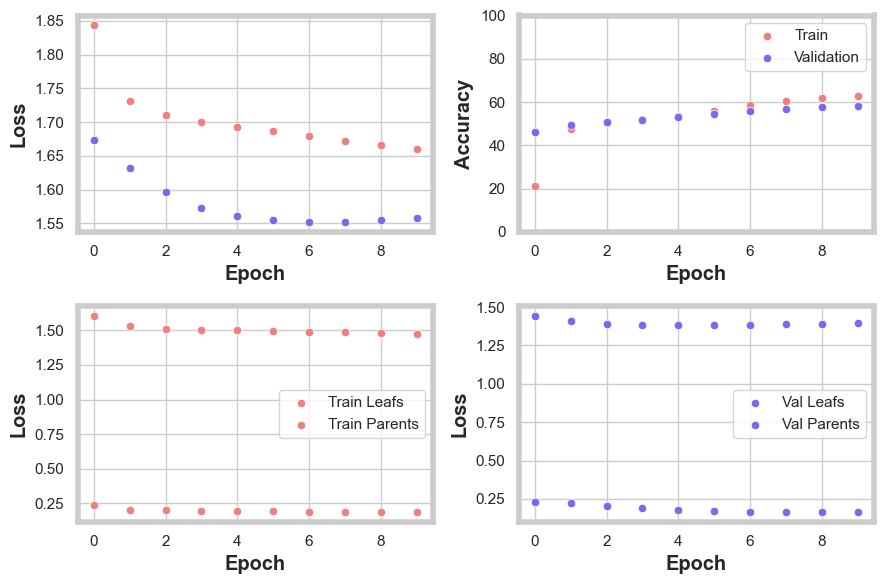

In [24]:
fig, ax = plt.subplots(2,2,figsize=(9,6))
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_hist'], ax = ax[0,0],color='lightcoral')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['accuracy_train_hist'], ax = ax[0,1],color='lightcoral',label='Train')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_hist'], ax = ax[0,0],color='mediumslateblue')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['accuracy_val_hist'], ax = ax[0,1],color='mediumslateblue',label='Validation')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_leaf_hist'], ax = ax[1,0],color='lightcoral',label='Train Leafs')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_train_parents_hist'], ax = ax[1,0],color='lightcoral',label='Train Parents')

sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_leaf_hist'], ax = ax[1,1],color='mediumslateblue',label='Val Leafs')
sns.scatterplot(x=range(num_epochs),y=marginalization_dict['loss_val_parents_hist'], ax = ax[1,1],color='mediumslateblue',label='Val Parents')


ax[0,0].set_xlabel('Epoch')
ax[0,1].set_xlabel('Epoch')
ax[1,0].set_xlabel('Epoch')
ax[1,1].set_xlabel('Epoch')

ax[0,0].set_ylabel('Loss')
ax[0,1].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[1,1].set_ylabel('Loss')

ax[0,1].set_ylim((0,100))
fig.show()

In [50]:
y_train

tensor([0, 0, 2,  ..., 0, 2, 0])

In [45]:
label_dict

{0: 'CL:0000900',
 1: 'CL:0000934',
 2: 'CL:0001044',
 3: 'CL:0001049',
 4: 'CL:0001050'}